In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import create_shifted_rt, uniform_clustering
os.chdir('./notebooks')

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice Nikkey (**^N225**) e o da ação da Toyota (**7203.T**), entre 22/02/1985 e 30/12/2008.

In [2]:
df_nikkey = yf.download("^N225", start="1984-10-01", end="2008-12-30")
df_toyota = yf.download("7203.T", start="1985-02-21", end="2008-12-30")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


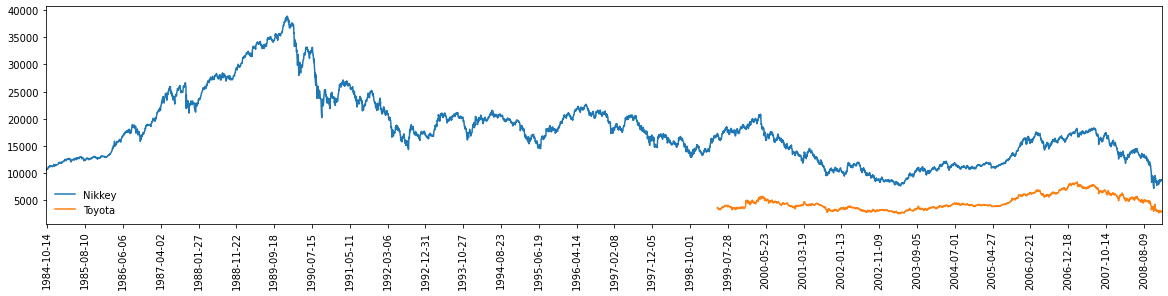

In [3]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_nikkey['Close'], label="Nikkey")
ax.plot(df_toyota['Close'], label="Toyota")

date_min = df_nikkey.index.min()
date_max = df_nikkey.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [4]:
X_train = df_nikkey[:"2008-11-30"]
X_test = df_nikkey["2008-12-01":]

print(f"""Base original: {df_nikkey.shape}
X_train: {X_train.shape}
X_test: {X_test.shape}\n""")

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = X_train[["Close", "rt"]][1:]
X_train.head()

Base original: (5976, 6)
X_train: (5956, 6)
X_test: (20, 6)



,Close,rt
Date,,
1984-10-02,10540.049805,-1.073343
1984-10-03,10587.379883,0.448045
1984-10-04,10642.070312,0.515233
1984-10-05,10737.580078,0.893470
1984-10-08,10676.929688,-0.566444


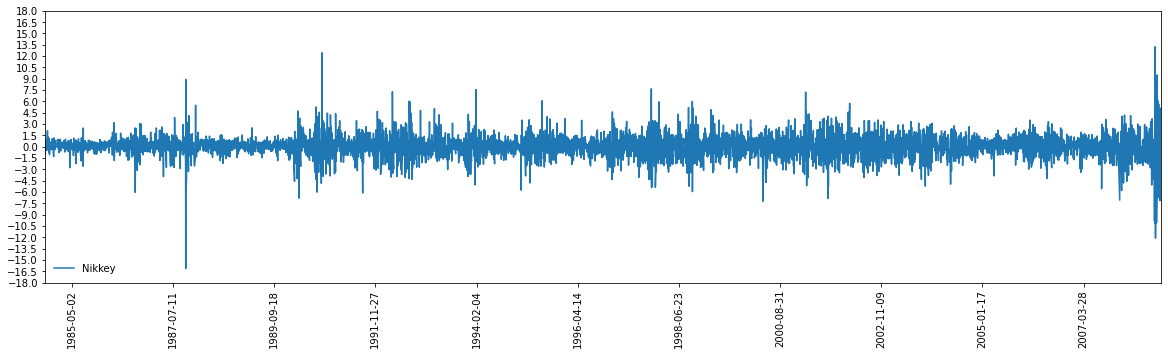

In [5]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = X_train.index.min()
date_max = X_train.index.max()

ax.plot(X_train['rt'], label="Nikkey")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [6]:
X_train = uniform_clustering(X_train, ["rt"])
X_train.head()

,Close,rt,cluster_rt
Date,,,
1984-10-02,10540.049805,-1.073343,2.0
1984-10-03,10587.379883,0.448045,5.0
1984-10-04,10642.070312,0.515233,5.0
1984-10-05,10737.580078,0.893470,5.0
1984-10-08,10676.929688,-0.566444,2.0


Comparando agrupamento abtido com o agrupamento exposto no artigo.


![2012_zuo_table_01_uniform_clustering](../reports/figures/2012_zuo_table_01_uniform_clustering.png)

In [7]:
round(X_train.groupby(by=["cluster_rt"]).agg({"rt": ["min", "max","count", "mean"]}), 2).reset_index()

cluster_rt     rt                   
                min    max count  mean
0        1.0 -16.14  -1.12   975 -2.18
1        2.0  -1.12  -0.42   973 -0.73
2        3.0  -0.42  -0.00   966 -0.20
3        4.0   0.00   0.44   997  0.21
4        5.0   0.44   1.07  1034  0.71
5        6.0   1.07  13.23  1010  2.03

### Adição de atributos conforme a rede bayesiana obtida

De acordo com os autores, usando o algoritmo K2, eles obtiveram a seguinte rede bayesiana:

``` dot

digraph G{
    rt-1 -> rt
    rt-5 -> rt
    rt-37 -> rt
}

```


Portanto, serão adicionados os seguintes atributos: **rt-1**, **rt-5** e **rt-37**, sendo que o número indica a quantidade de dias atrás que é necessário.

In [8]:
X_train = df_nikkey.loc[:"2008-11-30", ["Close"]]

X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
X_train = create_shifted_rt(X_train, [1, 5, 37])
X_train = uniform_clustering(X_train, ["rt", "rt-1", "rt-5", "rt-37"])

X_train = X_train["1985-02-22":]

X_train.head(10)

,Close,rt,rt-1,rt-5,rt-37,cluster_rt,cluster_rt-1,cluster_rt-5,cluster_rt-37
Date,,,,,,,,,
1985-02-22,12147.059570,0.153238,-0.196947,0.549730,0.020010,4.0,3.0,5.0,4.0
1985-02-25,12201.040039,0.443407,0.153238,0.007082,0.164989,5.0,4.0,4.0,4.0
1985-02-26,12194.969727,-0.049765,0.443407,0.061625,0.251814,3.0,5.0,4.0,4.0
1985-02-27,12287.379883,0.754916,-0.049765,-0.035127,0.003469,5.0,3.0,3.0,4.0
1985-02-28,12321.919922,0.280707,0.754916,-0.196947,0.130380,4.0,5.0,3.0,4.0
1985-03-01,12412.139648,0.729521,0.280707,0.153238,0.150949,5.0,4.0,4.0,4.0
1985-03-04,12509.009766,0.777417,0.729521,0.443407,0.896752,5.0,5.0,5.0,5.0
1985-03-05,12476.379883,-0.261192,0.777417,-0.049765,0.714749,3.0,5.0,3.0,5.0
1985-03-06,12498.669922,0.178499,-0.261192,0.754916,0.515600,4.0,3.0,5.0,5.0


In [9]:
print(X_train.shape)
print(X_test.shape)

(5859, 9)
(20, 6)


### Preparando conjunto de validação


In [10]:
X_test = df_nikkey.loc["2008-09-01":, ["Close"]]

X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
X_test = create_shifted_rt(X_test, [1, 5, 37])
X_test = uniform_clustering(X_test, ["rt", "rt-1", "rt-5", "rt-37"])

X_test = X_test["2008-12-01":]
X_test.tail(10)


,Close,rt,rt-1,rt-5,rt-37,cluster_rt,cluster_rt-1,cluster_rt-5,cluster_rt-37
Date,,,,,,,,,
2008-12-15,8664.660156,5.075368,-5.718327,5.067265,3.284074,6.0,1.0,6.0,6.0
2008-12-16,8568.019531,-1.121609,5.075368,0.799055,-7.027658,1.0,6.0,5.0,1.0
2008-12-17,8612.519531,0.518029,-1.121609,3.100253,-2.494458,5.0,1.0,6.0,1.0
2008-12-18,8667.230469,0.633240,0.518029,0.693982,-10.087967,5.0,5.0,5.0,1.0
2008-12-19,8588.519531,-0.912293,0.633240,-5.718327,-6.567048,2.0,5.0,1.0,1.0
2008-12-22,8723.780273,1.562629,-0.912293,5.075368,6.211338,6.0,2.0,6.0,6.0
2008-12-24,8517.099609,-2.397680,1.562629,-1.121609,7.455607,1.0,6.0,1.0,6.0
2008-12-25,8599.500000,0.962820,-2.397680,0.518029,9.494139,5.0,1.0,5.0,6.0
2008-12-26,8739.519531,1.615115,0.962820,0.633240,-5.144384,6.0,5.0,5.0,1.0


## Treinando um modelo

Vamos testar primeiro um **Naive Bayes** (❗ no paper, não é usado esse modelo, estamos apenas testando):

In [11]:
model = GaussianNB()
model.fit(X_train[["cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]], X_train["cluster_rt"])

GaussianNB()

### Prevendo e avaliando preliminarmente

Primeiro, vamos ver como fica a acurácia e a proporção de acertos por classe.

In [12]:
y_pred = model.predict(X_test[["cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]])
X_test_ = X_test.copy()

X_test_["y_pred"] = y_pred

X_test_

,Close,rt,rt-1,rt-5,rt-37,cluster_rt,cluster_rt-1,cluster_rt-5,cluster_rt-37,y_pred
Date,,,,,,,,,,
2008-12-01,8397.219727,-1.360793,1.644982,2.661259,-4.344664,1.0,6.0,6.0,1.0,1.0
2008-12-02,7863.689941,-6.564471,-1.360793,5.090681,-3.075424,1.0,1.0,6.0,1.0,1.0
2008-12-03,8004.100098,1.769797,-6.564471,-1.338944,-9.849053,6.0,1.0,1.0,1.0,1.0
2008-12-04,7924.240234,-1.002748,1.769797,1.931376,-0.499217,2.0,6.0,6.0,2.0,4.0
2008-12-05,7917.509766,-0.084971,-1.002748,1.644982,-10.116047,3.0,2.0,6.0,1.0,1.0
2008-12-08,8329.049805,5.067265,-0.084971,-1.360793,13.234592,6.0,3.0,1.0,6.0,6.0
2008-12-09,8395.870117,0.799055,5.067265,-6.564471,1.051857,5.0,6.0,1.0,5.0,6.0
2008-12-10,8660.240234,3.100253,0.799055,1.769797,-12.111020,6.0,5.0,6.0,1.0,1.0
2008-12-11,8720.549805,0.693982,3.100253,-1.002748,2.744650,5.0,6.0,2.0,6.0,6.0


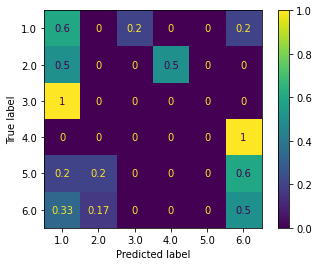

In [13]:
plot_confusion_matrix(model, X_test_[["cluster_rt-1", "cluster_rt-5", "cluster_rt-37"]], X_test_["cluster_rt"], normalize='true');

In [14]:
accuracy_score(X_test_["cluster_rt"], y_pred, normalize=True)

0.3

Agora, vamos avaliar as métricas indicadas no artigo:

![2012_zuo_table_04_prediction_errors](../reports/figures/2012_zuo_table_04_prediction_errors.png)

![2012_zuo_rmse_cc](../reports/figures/2012_zuo_rmse_cc.png)

## Achando a estrutura da rede

In [15]:
# sequencia = np.arange(1, 12, 4)
sequencia = [1,5,37]
sequencia_rt = list(["rt-"+str(_) for _ in sequencia][::-1])
sequencia_rt.append('rt')

print(f"""\nTamanho da sequência: {len(sequencia)}
Sequência: {sequencia_rt}""")


Tamanho da sequência: 3
Sequência: ['rt-37', 'rt-5', 'rt-1', 'rt']


In [16]:
X_train_network = X_train[["rt"]].copy()
X_train_network = create_shifted_rt(X_train_network, sequencia)
X_train_network = uniform_clustering(X_train_network, sequencia_rt)

X_train_network.dropna(how="any", axis=0, inplace=True)
# X_train_network = X_train_network.sample(100, random_state=0).copy()
X_train_network = X_train_network.iloc[-1000:,]
X_train_network = X_train_network[[column for column in X_train_network.columns if 'cluster_' in column]]

print(f"Tamanho: {X_train_network.shape}")

X_train_network.tail(5)

Tamanho: (1000, 4)


,cluster_rt-37,cluster_rt-5,cluster_rt-1,cluster_rt
Date,,,,
2008-11-21,1.0,6.0,1.0,6.0
2008-11-25,1.0,5.0,6.0,6.0
2008-11-26,5.0,1.0,6.0,1.0
2008-11-27,1.0,2.0,1.0,6.0
2008-11-28,1.0,1.0,6.0,6.0


In [17]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, K2Score, BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

bic = BicScore(X_train_network)
k2 = K2Score(X_train_network)

scoring_method = k2

serch_method =  "HillClimbSearch" # or "ExhaustiveSearch"

if serch_method == "ExhaustiveSearch":
    print("ExhaustiveSearch")
    es = ExhaustiveSearch(X_train_network, scoring_method=scoring_method)
    best_model = es.estimate()

    print("All DAGs by score:")
    for score, dag in reversed(es.all_scores()):
        if (len(dag.edges()) >= 3): # and ("cluster_rt" in dag.edges())
            print(score, dag.edges())
        # print(score, len(dag.edges()))
        # print(score, dag.edges())
else:
    print("HillClimbSearch")
    es = HillClimbSearch(X_train_network, scoring_method=scoring_method)
    best_model = es.estimate(max_indegree=5, scoring_method=scoring_method, max_iter=1000)

    for combination in best_model.edges():
        print(combination)

        
# hc = HillClimbSearch(data, scoring_method=BicScore(data))
# best_model = hc.estimate()
# print(best_model.edges())

  0%|          | 0/1000 [00:00<?, ?it/s]HillClimbSearch



Usar a busca exaustiva para mais de 5 nós é muito exaustivo....

# Outra abordagem: impondo a estrutura

In [18]:
X_train_network.columns

Index(['cluster_rt-37', 'cluster_rt-5', 'cluster_rt-1', 'cluster_rt'], dtype='object')

In [19]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.models import BayesianModel

model = BayesianModel([('cluster_rt-37', 'cluster_rt'), ('cluster_rt-5', 'cluster_rt'), ('cluster_rt-1', 'cluster_rt')])

# # disable text wrapping in output cell
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(X_train_network, 
          estimator=BayesianEstimator,
          prior_type="k2",
          equivalent_sample_size=10,
          complete_samples_only=False)

# print(f'Check model: {model.check_model()}\n')
# for cpd in model.get_cpds():
#     print(f'CPT of {cpd.variable}:')
#     print(cpd, '\n')

In [20]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

g_dist = infer.query(['cluster_rt'])
print(g_dist)

Eliminating: cluster_rt-5: 100%|██████████| 3/3 [00:00<00:00, 198.07it/s]+-----------------+-------------------+
| cluster_rt      |   phi(cluster_rt) |
+=================+===================+
| cluster_rt(1.0) |            0.1624 |
+-----------------+-------------------+
| cluster_rt(2.0) |            0.1616 |
+-----------------+-------------------+
| cluster_rt(3.0) |            0.1663 |
+-----------------+-------------------+
| cluster_rt(4.0) |            0.1694 |
+-----------------+-------------------+
| cluster_rt(5.0) |            0.1650 |
+-----------------+-------------------+
| cluster_rt(6.0) |            0.1754 |
+-----------------+-------------------+



In [22]:
# print(infer.query(['cluster_rt'], evidence={'cluster_rt-1':  6.0, 'cluster_rt-5':  1.0, 'cluster_rt-37': 6.0}))
infer.map_query(['cluster_rt'], evidence={'cluster_rt-1':  6.0, 'cluster_rt-5':  1.0, 'cluster_rt-37': 6.0})

Finding Elimination Order: : : 0it [00:10, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'cluster_rt': 5.0}

In [26]:
from datetime import date

today = date.today()
print("Today's date:", today)

X_train_network.iloc[-1, X_train_network.columns[cluster_rt-37]]

Today's date: 2021-06-21


cluster_rt-37    1.0
cluster_rt-5     1.0
cluster_rt-1     6.0
cluster_rt       6.0
Name: 2008-11-28 00:00:00, dtype: float64

In [33]:
df_clustered = X_train_network.copy()

evidence = {}

for i, item in zip(df_clustered.iloc[-1].index, df_clustered.iloc[-1]):
    evidence[i] = item

evidence

{'cluster_rt-37': 1.0,
 'cluster_rt-5': 1.0,
 'cluster_rt-1': 6.0,
 'cluster_rt': 6.0}

In [39]:
evidence = {
    'cluster_rt-37': df_clustered.iloc[-37]['cluster_rt'],
    'cluster_rt-5': df_clustered.iloc[-5]['cluster_rt'],
    'cluster_rt-1': df_clustered.iloc[-1]['cluster_rt'],
    }
evidence

{'cluster_rt-37': 1.0, 'cluster_rt-5': 6.0, 'cluster_rt-1': 6.0}